# Code to download HYCOM data from ERDDAP
Author: Johanna Wren

Date: Sept 18, 2025

email: johanna.wren@noaa.gov

Description: Here is some code to access HYCOM data via erddap and subset then download the data. Becuase this version of HYCOM is on a -180/180 longitude, we have to change that to 0/360 and reorder the x-axis. I have outlined both a step by step process and at the end put it all together into a loop so you can just start that kernel and run it, or better yet, save that bit as a .py script and run and park it on a server somewhere. 

In [1]:
import xarray as xr
import netCDF4 as nc

### Access the dataset on erddap using xarray

In [2]:
myDat = xr.open_dataset('https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_e9ba_92b1_0bcd')
myDat

<xarray.Dataset> Size: 341TB
Dimensions:     (time: 59168, LEV: 40, latitude: 2001, longitude: 4500)
Coordinates:
  * time        (time) datetime64[ns] 473kB 1992-10-02 ... 2012-12-31T21:00:00
  * LEV         (LEV) float64 320B 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * latitude    (latitude) float64 16kB -80.0 -79.92 -79.84 ... 79.84 79.92 80.0
  * longitude   (longitude) float64 36kB -180.0 -179.9 -179.8 ... 179.8 179.9
Data variables:
    water_u     (time, LEV, latitude, longitude) float32 85TB ...
    water_v     (time, LEV, latitude, longitude) float32 85TB ...
    water_temp  (time, LEV, latitude, longitude) float32 85TB ...
    salinity    (time, LEV, latitude, longitude) float32 85TB ...
Attributes: (12/28)
    cdm_data_type:             Grid
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_email:             forum@hycom.org
    creator_name:              APDRC
    creator_type:              institution
    creator_url:               https://hycom.org/
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   data apdrc.soest.hawaii.edu dods public ofes H...
    time_coverage_end:         2012-12-31T21:00:00Z
    time_coverage_start:       1992-10-02T00:00:00Z
    title:                     data apdrc.soest.hawaii.edu dods public ofes H...
    Westernmost_Easting:       -180.0

Then subset the dataset in time and depth and turn 180/-180 into 0-360

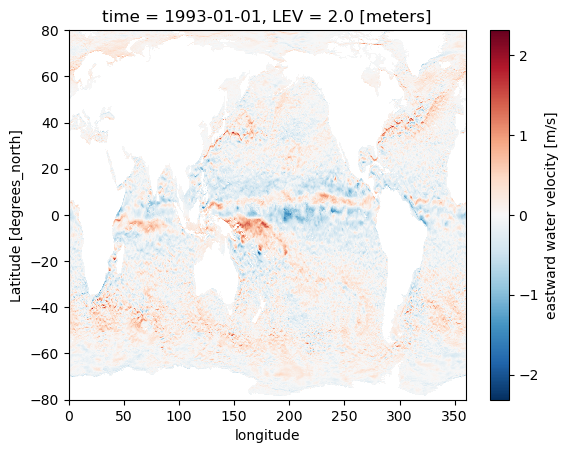

In [ ]:
# subset
test = myDat[['water_u', 'water_v']].sel(time='1993-01-01T00:00:00', LEV=[2,6,20,60,250])

# change from 180/-180 to 0-360 se we can crop over the dateline
test = test.assign_coords(longitude=((360 + (test.longitude % 360)) % 360))
test = test.roll(longitude=int(len(test['longitude']) / 2),roll_coords=True)

# See if it worked
test.water_u.sel(LEV=2).plot()


Then slice out the spatial area you want

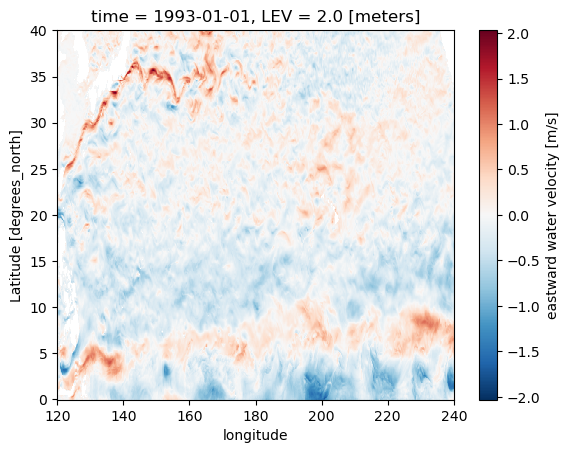

In [5]:
# Subset for the lon and lat you want
test2 = test.sel(longitude=slice(120,240), latitude=slice(0,40))

# Just to make sure it looks right, I plotted U for 2m depth
test2.water_u.sel(LEV=2).plot()

Save the data

In [ ]:
# Save data
test2.to_netcdf('~/Desktop/HYCOMdata/testhycom2.nc')

## Here is everything above put together into a loop
I am looping over 3h increments. I found that the first day was blank so I started one day earlier than I needed, but play around with it to see what works for you. 

**CHANGE THE `range(10)` TO HOWEVER MANY FILES YOU WANT TO LOOP THROUGH**


In [41]:
import xarray as xr
import netCDF4 as nc
from datetime import timedelta, datetime

# Load HYCOM dataset metadata
myDat = xr.open_dataset('https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_e9ba_92b1_0bcd')

# Start looping through time (every 3h)
start_date = datetime(1993, 1, 1, 9, 0, 0)
for td in (start_date + timedelta(hours=3*it) for it in range(6)):  # change the range here to the number of files you want to download. One year would be 365*8 since they are 3h files, so 8 each day
    print(td)
    # subset
    test = myDat[['water_u', 'water_v']].sel(time=td.strftime("%Y-%m-%dT%H:%M:%S"), LEV=[2,6,20,60,250], latitude=slice(0,40))

    # change from 180/-180 to 0-360 se we can crop over the dateline
    test = test.assign_coords(longitude=((360 + (test.longitude % 360)) % 360))
    test = test.roll(longitude=int(len(test['longitude']) / 2),roll_coords=True)

    # Subset for the lon and lat you want
    test2 = test.sel(longitude=slice(120,240))

    # Renaming the depth variable becuase I really don't like LEV
    test2.rename({'LEV' : 'depth'})

    # Save data
    print('Saving file')
    test2.to_netcdf(''.join(['HYCOMdata/HYCOM_', td.strftime('%Y%m%d%H'), '.nc']))


1993-01-01 09:00:00
Saving file
1993-01-01 12:00:00


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!doctype^ html><html lang="en"><head><title>HTTP Status 404 – Not Found</title><style type="text/css">h1 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:22px;} h2 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:16px;} h3 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:14px;} body {font-family:Tahoma,Arial,sans-serif;color:black;background-color:white;} b {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;} p {font-family:Tahoma,Arial,sans-serif;background:white;color:black;font-size:12px;} a {color:black;} a.name {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 404 – Not Found</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Resource not found: /erddap/griddap/hawaii_soest_e9ba_92b

Saving file
1993-01-01 15:00:00


KeyboardInterrupt: 

<xarray.DataArray 'longitude' ()> Size: 8B
array(-180.)
Coordinates:
    time     datetime64[ns] 8B 1993-01-01